In [ ]:
from sympy import *
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp
import numpy as np
from scipy import signal
from IPython.display import display, Latex
from sympy.physics.vector import vlatex, dynamicsymbols

In [ ]:
def printEquations(n, m, L, P, f, q, vq, t, eps):
    L = simplify(L)
    display(Latex("${} = {}$".format(latex("L"), vlatex(L))))
    
    expr = []
    ddtheta = []
    lam = []

    for i in range(m):
        lam.append(Symbol("lambda"+str(i+1)))

    for i in range(n):
      expr.append(diff(L, q[i]) + diff(P, vq[i]) - diff(diff(L, vq[i]),t))

      for j in range(m):
            expr[i]+=lam[j]*diff(f[j],q[i])
      print("\n")

      expr[i] = Eq(simplify(expr[i]), 0)
      display(Latex(vlatex(expr[i])))
      ddtheta.append(diff(vq[i], t))

    for i in range(m):
      expr.append(diff(f[i],t,t) + 2*eps*diff(f[i],t) + eps*eps*f[i])
      expr[i + n] = Eq(simplify(expr[i + n]), 0)

      print("\n")
      display(Latex(vlatex(expr[i + n])))
      ddtheta.append(lam[i])
    
    ddtheta = tuple(ddtheta)
    solutions = list(list(linsolve(expr, ddtheta))[0])

    for i in range(n):
      solution = Eq(diff(vq[i], t), simplify(solutions[i]))
      print("\n")
      display(Latex(vlatex(solution)))

    for i in range(m):
      solution = Eq(lam[i], simplify(solutions[i + n]))
      print("\n")
      display(Latex(vlatex(solution)))

    return solutions

In [ ]:
t = Symbol('t')

m = Symbol('m')
l = Symbol('l')

eps = Symbol('varepsilon')
b = Symbol('b')
g = Symbol('g')

phi = dynamicsymbols('phi')
dphi = diff(phi, t)
ro = dynamicsymbols('rho')
dro = diff(ro, t)

M = dynamicsymbols('M')

L = m / 2 * (dphi ** 2 * ro ** 2 + dro ** 2) + m * g * ro * cos(phi)
P = M * dphi - b * (ro * dphi) ** 2 / 2 - b * dro ** 2 / 2
f = ro - l

original_equations = printEquations(2, 1, L, P, [f], [phi,ro], [dphi,dro], t, eps)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [ ]:
def makeEquations(n, mass, length, epsilon, gravity, x, equations):
  res = []
  for i in range(n):
    expr = equations[i]

    expr = expr.subs(m, mass)
    expr = expr.subs(l, length)

    expr = expr.subs(eps, epsilon)
    expr = expr.subs(g, gravity)

    expr = simplify(expr)
    sol = Eq(x[i], expr)
    display(Latex(vlatex(sol)))
    print("\n")

    res.append(expr)

  return res
    

In [ ]:
mass = 5
length = 1
gravity = 9.81
epsilon = 5

equations = makeEquations(3, mass, length, epsilon, gravity, [diff(dphi, t), diff(dro, t), Symbol('lambda_1')], original_equations)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [ ]:
f1 = lambdify([phi, ro, dphi, dro, M, b], equations[0])
f2 = lambdify([phi, ro, dphi, dro, M], equations[1])
f3 = lambdify([phi, ro, dphi, dro, M, b], equations[2], 'numpy')

In [ ]:
def odes(t, y, M, b, f1, f2):
  q1 = y[0]
  dq1 = y[1]
  q2 = y[2]
  dq2 = y[3]

  moment = M(t)

  return [dq1, f1(q1, q2, dq1, dq2, moment, b), dq2, f2(q1, q2, dq1, dq2, moment)]

In [ ]:
def resiAnaliticki(moment, b, q1_0, dq1_0, q2, dq2):

  eq = equations[0].subs(dro, 0)
  eq = eq.subs(ro, length)

  eq = eq.subs(cos(phi), 1)
  eq = eq.subs(sin(phi), phi)

  eq = eq.subs(Symbol('b'), b)
  eq = eq.subs(M, moment)
  eq = diff(dphi, t) - eq

  display(Latex("${} = {}$".format(vlatex(eq), 0)))

  sol = dsolve(eq, phi)
  display(Latex(vlatex(sol)))

  phi_analytical = dsolve(eq, phi, ics={phi.subs(t,0): q1_0, dphi.subs(t,0): dq1_0})
  display(Latex(vlatex(phi_analytical)))

  lambda1_analytical = equations[2].subs([(phi, phi_analytical.rhs), (dphi, diff(phi_analytical, t)), (ro, q2), (dro, dq2), (Symbol('b'), b)])
  lambda1_analytical = simplify(lambda1_analytical)

  display(Latex(vlatex(Eq(Symbol('lambda_1'), lambda1_analytical))))

  return lambda1_analytical

### $M=0$

In [ ]:
M1 = lambdify([t], 0)
phi_0 = pi/3
rho_0 = length
dphi_0 = 2

tspan = np.linspace(0, 10, 100000)
sol = solve_ivp(fun = lambda t, y: odes(t, y, M1, 0, f1, f2), t_span = [tspan[0], tspan[-1]], y0 = [phi_0, dphi_0, rho_0, 0], t_eval = tspan)

Text(0, 0.5, 'ugao otklona')

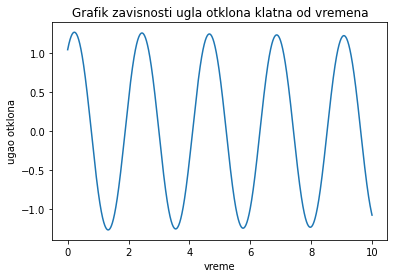

In [ ]:
plt.plot(sol.t, sol.y[0])
plt.title("Grafik zavisnosti ugla otklona klatna od vremena")
plt.xlabel("vreme")
plt.ylabel("ugao otklona")

Text(0, 0.5, 'ugaona brzina klatna')

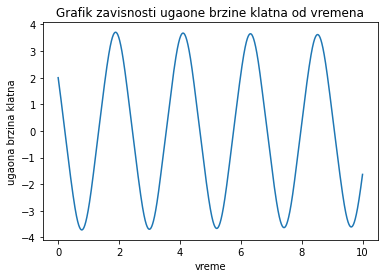

In [ ]:
plt.plot(sol.t, sol.y[1])
plt.title("Grafik zavisnosti ugaone brzine klatna od vremena")
plt.xlabel("vreme")
plt.ylabel("ugaona brzina klatna")

Text(0, 0.5, 'y-osa')

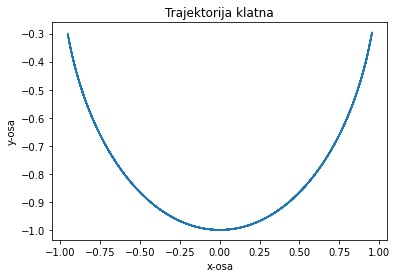

In [ ]:
plt.plot(sol.y[2]*np.sin(sol.y[0]), -sol.y[2]*np.cos(sol.y[0]))
plt.title("Trajektorija klatna")
plt.xlabel("x-osa")
plt.ylabel("y-osa")

Text(0, 0.5, 'ugaona brzina')

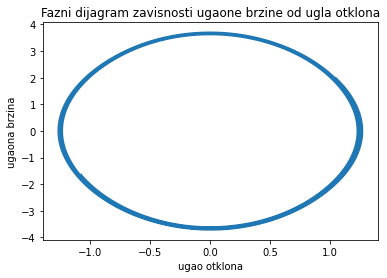

In [ ]:
plt.plot(sol.y[0], sol.y[1])
plt.title("Fazni dijagram zavisnosti ugaone brzine od ugla otklona")
plt.xlabel("ugao otklona")
plt.ylabel("ugaona brzina")

In [ ]:
const_analytical = resiAnaliticki(0, 0, phi_0, dphi_0, rho_0, 0)
const_analytical = lambdify([t], const_analytical)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Text(0, 0.5, 'sila ogranicenja')

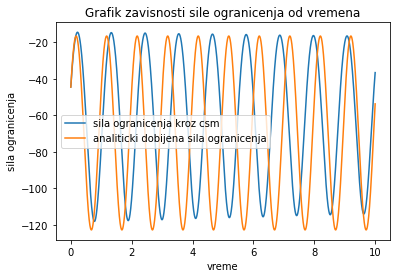

In [ ]:
plt.plot(sol.t, f3(sol.y[0], sol.y[2], sol.y[1], sol.y[3], M1(sol.t), 0), label = "sila ogranicenja kroz csm")
plt.plot(sol.t, const_analytical(sol.t), label = "analiticki dobijena sila ogranicenja")
plt.legend()
plt.title("Grafik zavisnosti sile ogranicenja od vremena")
plt.xlabel("vreme")
plt.ylabel("sila ogranicenja")

Text(0, 0.5, 'funkcija ogranicenja')

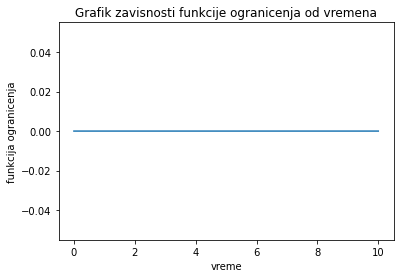

In [ ]:
plt.plot(sol.t, sol.y[2]-length)
plt.title("Grafik zavisnosti funkcije ogranicenja od vremena")
plt.xlabel("vreme")
plt.ylabel("funkcija ogranicenja")

### $M=M_a\cos{\Omega t}$

In [ ]:
Ma = 5
omega = 4
b = 0.5

phi_0 = pi/20
rho_0 = length
dphi_0 = 0

M2 = lambdify([t], Ma * cos(omega * t))

tspan = np.linspace(0, 15, 100000)
sol = solve_ivp(fun = lambda t, y: odes(t, y, M2, b, f1, f2), t_span = [tspan[0], tspan[-1]], y0 = [phi_0, dphi_0, rho_0, 0], t_eval = tspan)

Text(0, 0.5, 'ugao otklona')

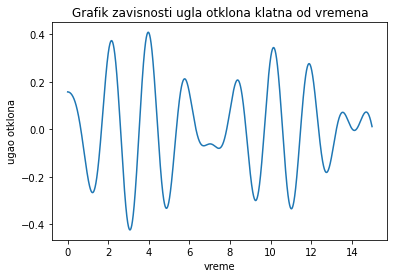

In [ ]:
plt.plot(sol.t, sol.y[0])
plt.title("Grafik zavisnosti ugla otklona klatna od vremena")
plt.xlabel("vreme")
plt.ylabel("ugao otklona")

Text(0, 0.5, 'ugaona brzina klatna')

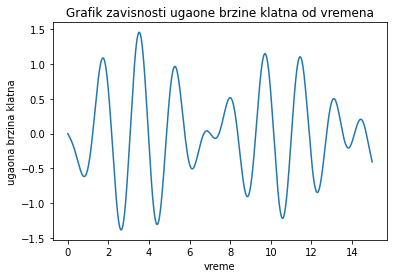

In [ ]:
plt.plot(sol.t, sol.y[1])
plt.title("Grafik zavisnosti ugaone brzine klatna od vremena")
plt.xlabel("vreme")
plt.ylabel("ugaona brzina klatna")

Text(0, 0.5, 'y-osa')

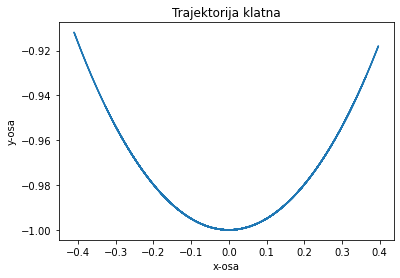

In [ ]:
plt.plot(sol.y[2]*np.sin(sol.y[0]), -sol.y[2]*np.cos(sol.y[0]))
plt.title("Trajektorija klatna")
plt.xlabel("x-osa")
plt.ylabel("y-osa")

Text(0, 0.5, 'ugaona brzina')

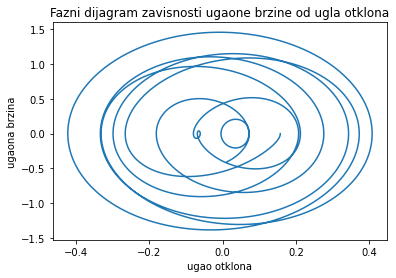

In [ ]:
plt.plot(sol.y[0], sol.y[1])
plt.title("Fazni dijagram zavisnosti ugaone brzine od ugla otklona")
plt.xlabel("ugao otklona")
plt.ylabel("ugaona brzina")

In [ ]:
const_analytical = resiAnaliticki(Ma * cos(omega * t), b, phi_0, dphi_0, rho_0, 0)
const_analytical = lambdify([t], const_analytical)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Text(0, 0.5, 'sila ogranicenja')

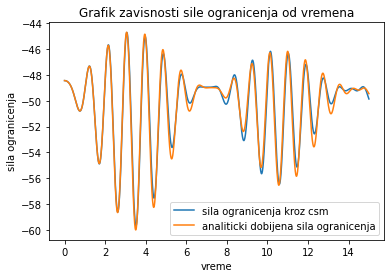

In [ ]:
plt.plot(sol.t, f3(sol.y[0], sol.y[2], sol.y[1], sol.y[3], M1(sol.t), b), label = "sila ogranicenja kroz csm")
plt.plot(sol.t, const_analytical(sol.t), label = "analiticki dobijena sila ogranicenja")
plt.legend()
plt.title("Grafik zavisnosti sile ogranicenja od vremena")
plt.xlabel("vreme")
plt.ylabel("sila ogranicenja")

In [ ]:
# grafici funkcija ogranicenja u vremenu su identicni za oba momenta kao i kod slucaja slobodnih oscilacija

### $M=M_a\cdot \text{square}(\Omega t)$

In [ ]:
Ma = 2
omega = 4
b = 5

phi_0 = pi/20
rho_0 = length
dphi_0 = 0

M3 = lambda t: Ma * signal.square(omega * t)

tspan = np.linspace(0, 15, 100000)
sol = solve_ivp(fun = lambda t, y: odes(t, y, M3, b, f1, f2), t_span = [tspan[0], tspan[-1]], y0 = [phi_0, dphi_0, rho_0, 0], t_eval = tspan)

Text(0, 0.5, 'ugao otklona')

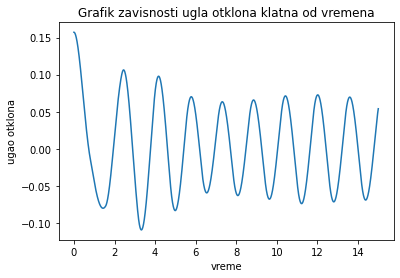

In [ ]:
plt.plot(sol.t, sol.y[0])
plt.title("Grafik zavisnosti ugla otklona klatna od vremena")
plt.xlabel("vreme")
plt.ylabel("ugao otklona")

Text(0, 0.5, 'ugaona brzina klatna')

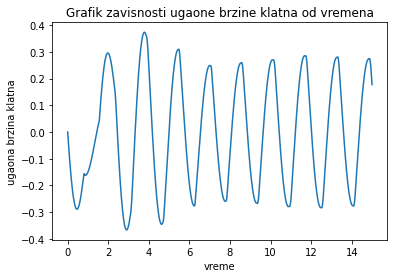

In [ ]:
plt.plot(sol.t, sol.y[1])
plt.title("Grafik zavisnosti ugaone brzine klatna od vremena")
plt.xlabel("vreme")
plt.ylabel("ugaona brzina klatna")

Text(0, 0.5, 'y-osa')

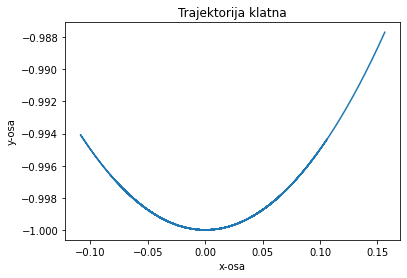

In [ ]:
plt.plot(sol.y[2]*np.sin(sol.y[0]), -sol.y[2]*np.cos(sol.y[0]))
plt.title("Trajektorija klatna")
plt.xlabel("x-osa")
plt.ylabel("y-osa")

Text(0, 0.5, 'ugaona brzina')

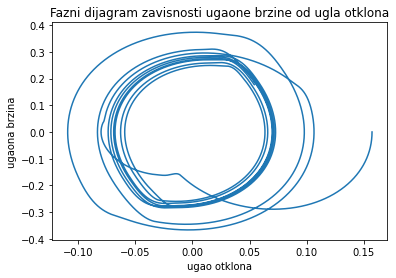

In [ ]:
plt.plot(sol.y[0], sol.y[1])
plt.title("Fazni dijagram zavisnosti ugaone brzine od ugla otklona")
plt.xlabel("ugao otklona")
plt.ylabel("ugaona brzina")

In [ ]:
#Diferencijalna jednacina i njeno "opste" resenje

eq = original_equations[0].subs(dro, 0)
eq = eq.subs(ro, l)

eq = eq.subs(cos(phi), 1)
eq = eq.subs(sin(phi), phi)

eq = diff(dphi, t) - eq

display(Latex("${} = {}$".format(vlatex(eq), 0)))

phi0 = Symbol('phi_0')
dphi0 = Symbol('omega_0')
phi_analytical = dsolve(eq, phi, ics={phi.subs(t,0): phi0, dphi.subs(t,0): dphi0})

display(Latex(vlatex(phi_analytical)))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [ ]:
#Ubacivanje parametara u "opste" resenje diferencijalne jednacine

bb = Symbol('b')

phi_analytical = phi_analytical.subs(sqrt(bb**2 * l**2 - 4 * g * l * m**2) / (2 * l * m), sqrt(l * (bb**2 * l - 4 * g * m**2)) / (2 * m * l))

I1 = M * exp(bb * t / (2 * m)) * exp(t * sqrt(l * (bb**2 * l - 4 * g * m**2)) / (2 * m * l))
I2 = M * exp(bb * t / (2 * m)) * exp(-t * sqrt(l * (bb**2 * l - 4 * g * m**2)) / (2 * m * l))

phi_analytical = phi_analytical.subs(Integral(I1, (t, 0)), 0)
phi_analytical = phi_analytical.subs(Integral(I2, (t, 0)), 0)
phi_analytical = phi_analytical.subs(Integral(I1, t), Function('I_1')(t)) #I1 i I2 predstavljaju funkicju ovog integrala
phi_analytical = phi_analytical.subs(Integral(I2, t), Function('I_2')(t))

display(Latex(vlatex(phi_analytical)))

phi_analytical = phi_analytical.subs(phi0, phi_0)
phi_analytical = phi_analytical.subs(dphi0, dphi_0)

phi_analytical = phi_analytical.subs(m, mass)
phi_analytical = phi_analytical.subs(g, gravity)
phi_analytical = phi_analytical.subs(bb, b)
phi_analytical = phi_analytical.subs(l, length)

dphi_analytical = diff(phi_analytical.rhs,t)

dphi_analytical = dphi_analytical.subs(diff(Function('I_1')(t),t), I1)
dphi_analytical = dphi_analytical.subs(diff(Function('I_2')(t),t), I2)


dphi_analytical = dphi_analytical.subs(m, mass)
dphi_analytical = dphi_analytical.subs(g, gravity)
dphi_analytical = dphi_analytical.subs(bb, b)
dphi_analytical = dphi_analytical.subs(l, length)

dphi_analytical = dphi_analytical.subs(M, 0) #Moze se pokazati da ce se M skratiti u ovom izrazu ako je t realan broj

print("\n")
display(Latex(vlatex(phi_analytical)))
print("\n")
display(Latex(vlatex(Eq(dphi,dphi_analytical))))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [ ]:
F1 = I1.subs(M, Ma)
F2 = I2.subs(M, Ma)

display(Latex(vlatex(Eq(Integral(F1, t), integrate(F1, t)))))
display(Latex(vlatex(Eq(Integral(F2, t), integrate(F2, t)))))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [ ]:
F1 = F1.subs([(bb, b), (m, mass), (l, length), (g, gravity)])

F2 = F2.subs([(bb, b), (m, mass), (l, length), (g, gravity)])

display(Latex(vlatex(Eq(Integral(F1, t), integrate(F1, t)))))
display(Latex(vlatex(Eq(Integral(F2, t), integrate(F2, t)))))

F1_analytical = integrate(F1, t)
F2_analytical = integrate(F2, t)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [ ]:
n = floor(t * omega / np.pi)

F1_0 = F1_analytical.evalf(subs = {t : 0})
R1 = - F1_analytical.evalf(subs = {t : np.pi / omega}) / F1_0
S1 = F1_0 * (1 - R1**(n + 1)) / (1 - R1)


F2_0 = F2_analytical.evalf(subs = {t : 0})
R2 = - F2_analytical.evalf(subs = {t : np.pi / omega}) / F2_0
S2 = F2_0 * (1 - R2**(n + 1)) / (1 - R2)

phi_analytical = phi_analytical.subs(Function('I_1')(t), F1_0 - 2 * S1 + (-1)**n * F1_analytical)
phi_analytical = phi_analytical.subs(Function('I_2')(t), F2_0 - 2 * S2 + (-1)**n * F2_analytical)

display(Latex(vlatex(phi_analytical)))

dphi_analytical = dphi_analytical.subs(Function('I_1')(t), F1_0 - 2 * S1 + (-1)**n * F1_analytical)
dphi_analytical = dphi_analytical.subs(Function('I_2')(t), F2_0 - 2 * S2 + (-1)**n * F2_analytical)

print("\n")
display(Latex(vlatex(Eq(dphi,dphi_analytical))))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [ ]:
#Konacna analiticka formula za silu ogranicenja
expr = equations[2].subs(dro, 0)
expr = expr.subs(ro, length)

lambda1_analytical = expr.subs([(dphi, dphi_analytical), (phi, phi_analytical.rhs)])

display(Latex(vlatex(Eq(Symbol('lambda_1'), lambda1_analytical))))

const_analytical = lambdify([t], lambda1_analytical)

<IPython.core.display.Latex object>

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0, 0.5, 'sila ogranicenja')

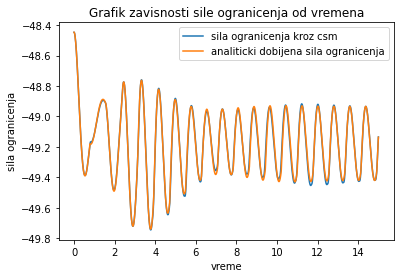

In [ ]:
plt.plot(sol.t, f3(sol.y[0], sol.y[2], sol.y[1], sol.y[3], M1(sol.t), b), label = "sila ogranicenja kroz csm")
plt.plot(np.linspace(0,15,100000), const_analytical(np.linspace(0,15,100000)), label = "analiticki dobijena sila ogranicenja")
plt.legend()
plt.title("Grafik zavisnosti sile ogranicenja od vremena")
plt.xlabel("vreme")
plt.ylabel("sila ogranicenja")

## Amplitudska karakteristika klatna

In [ ]:
Ma = 5
b = 5

freq = np.linspace(0.1, 10, 500)
ampl = []

for Omega in freq:
  M2 = lambdify([t], Ma * cos(Omega * t))

  tspan = np.linspace(0, min(100,100/Omega), int(min(1000,1000/Omega)))
  sol = solve_ivp(fun = lambda t, y: odes(t, y, M2, b, f1, f2), t_span = [tspan[0], tspan[-1]], y0 = [0, 0, length, 0], t_eval = tspan)

  ampl.append(max(sol.y[0][int(min(1000,1000/Omega))//2:int(min(1000,1000/Omega))]))

ampl = np.array(ampl)

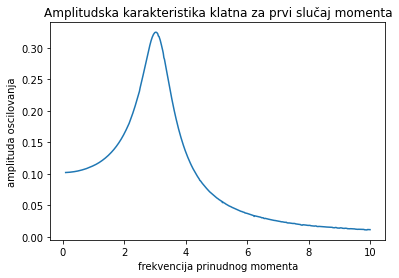

In [ ]:
plt.plot(freq, ampl)
plt.title("Amplitudska karakteristika klatna za prvi slučaj momenta")
plt.xlabel("frekvencija prinudnog momenta")
plt.ylabel("amplituda oscilovanja")
plt.show()

In [ ]:
Ma = 5
b = 5

freq = np.linspace(0.1, 10, 500)
ampl = []

for Omega in freq:
  M3 = lambda t: Ma * signal.square(Omega * t)

  tspan = np.linspace(0, min(150,150/Omega), int(min(2000,2000/Omega)))
  sol = solve_ivp(fun = lambda t, y: odes(t, y, M3, b, f1, f2), t_span = [tspan[0], tspan[-1]], y0 = [0, 0, length, 0], t_eval = tspan)

  ampl.append(max(sol.y[0][int(min(2000,2000/Omega)/2):int(min(2000,2000/Omega))]))

ampl = np.array(ampl)

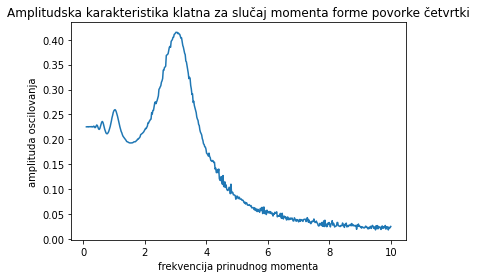

In [ ]:
plt.plot(freq, ampl)
plt.title("Amplitudska karakteristika klatna za slučaj momenta forme povorke četvrtki")
plt.xlabel("frekvencija prinudnog momenta")
plt.ylabel("amplituda oscilovanja")
plt.show()